In [0]:
from time import time
from pprint import pprint

In [0]:
import pandas as pd
import pyspark.sql.functions as func

### Reading data as pyspark.sql.DataFrame

In [0]:
data_file = "./data/yellow/*.csv"
# data_file = "./data/yellow_sample.csv"
csv_data = spark.read.csv(data_file, header= True, inferSchema=True)

In [0]:
csv_data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



Count trips by VendorID

In [0]:
csv_data.groupBy("VendorID").count().show()

+--------+--------+
|VendorID|   count|
+--------+--------+
|       1|23387018|
|       4|    2228|
|       2|30536489|
+--------+--------+



In [0]:
csv_data.select("VendorID").distinct().collect()

[Row(VendorID=1), Row(VendorID=4), Row(VendorID=2)]

There are 2228 records with VendorID = 4 but only VendorID = 1,2 have been mentioned in the data dictionary, we assume this is some sort of error in the source data, so we remove these records.

In [0]:
csv_data = csv_data.filter((csv_data.VendorID!=4))
print((csv_data.count(), len(csv_data.columns)))

(53923507, 17)


Creating trip_time column which shows the trip duration in minutes

In [0]:
csv_data = csv_data.withColumn("trip_time", func.round((func.unix_timestamp("tpep_dropoff_datetime")- func.unix_timestamp("tpep_pickup_datetime"))/60, 1))

Creating trip_month, trip_hour column based on pickup datetime which can be useful for time based analysis

In [0]:
csv_data = csv_data.withColumn("trip_month", func.month("tpep_pickup_datetime"))
csv_data = csv_data.withColumn("trip_hour", func.hour("tpep_pickup_datetime"))
csv_data = csv_data.withColumn("avg_trip_speed", func.round((func.col("trip_distance")/func.col("trip_time"))*60,2))
csv_data = csv_data.withColumn("worst_case_fare", func.round((func.col("trip_distance")*2)+3+(func.col("trip_time")/2),2))
# https://www.taxi-calculator.com/taxi-rate-new-york-city/259

Creating a temporary View for using SPARK SQL

In [0]:
csv_data.createOrReplaceTempView("csv_data_view")

Top 5 highest paid trips

In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view order by\
                  total_amount desc limit 5")
sqlDF.show()

+--------+--------------------+---------+-------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+-----------+----------+------------+------------+
|       1| 2018-04-01 13:32:18|      0.0|          0.0|  349026.72|       0.0|        5.76|   349116.78|
|       1| 2018-05-03 10:04:15|      0.0|          0.0|  234631.88|       0.0|         0.0|   234632.68|
|       1| 2018-03-30 19:53:59|      9.8|          1.4|  214748.44|       0.0|         0.0|   214750.24|
|       1| 2018-03-07 08:30:13|      4.4|          0.8|   200005.5|       0.0|         0.0|    200006.3|
|       1| 2018-06-03 00:38:21|     23.4|        101.9|     8018.8|       0.0|         0.0|      8019.6|
+--------+--------------------+---------+-------------+-----------+----------+------------+------------+



Top 5 lowest paid trips

In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view order by\
                  total_amount asc limit 5")
sqlDF.show()

+--------+--------------------+---------+-------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+-----------+----------+------------+------------+
|       2| 2018-05-05 19:42:15|     10.4|         0.01|     -485.0|       0.0|         0.0|      -485.8|
|       2| 2018-02-12 22:35:09|      4.6|         0.23|     -463.0|       0.0|         0.0|      -463.8|
|       2| 2018-02-01 22:54:33|      0.1|          0.0|    -453.09|       0.0|         0.0|     -453.39|
|       2| 2018-01-20 12:38:35|      0.1|          0.0|     -450.0|       0.0|         0.0|      -450.3|
|       2| 2018-02-06 05:20:54|     21.6|         0.11|    -445.55|       0.0|         0.0|     -445.85|
+--------+--------------------+---------+-------------+-----------+----------+------------+------------+



Top 5 peculiar trips interms of distance travelled and the amount paid

In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view order by\
                  trip_distance asc, total_amount desc limit 5")
sqlDF.show()

+--------+--------------------+---------+-------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+-----------+----------+------------+------------+
|       1| 2018-04-01 13:32:18|      0.0|          0.0|  349026.72|       0.0|        5.76|   349116.78|
|       1| 2018-05-03 10:04:15|      0.0|          0.0|  234631.88|       0.0|         0.0|   234632.68|
|       2| 2018-01-30 15:59:04|      0.2|          0.0|     5724.5|       0.0|         0.0|      5726.3|
|       1| 2018-03-09 16:26:46|      0.0|          0.0|     5000.0|       0.0|         0.0|      5150.0|
|       1| 2018-02-02 17:34:26|      0.0|          0.0|    2759.07|       0.0|         0.0|     2759.37|
+--------+--------------------+---------+-------------+-----------+----------+------------+------------+



In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance, avg_trip_speed,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view ORDER BY\
                  avg_trip_speed desc limit 5")
sqlDF.show()

+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|avg_trip_speed|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|       2| 2018-01-30 11:41:02|      1.1|    189483.84| 1.033548218E7|        4.0|       0.0|         0.0|         4.0|
|       1| 2018-04-05 07:21:35|      0.1|        943.5|      566100.0|       13.5|       0.0|         0.0|        14.3|
|       1| 2018-02-27 16:32:46|      0.1|        270.4|      162240.0|        6.5|       0.0|         0.0|       25.82|
|       1| 2018-05-28 20:28:32|      0.5|        910.8|      109296.0|      300.0|       0.0|         0.0|       300.3|
|       2| 2018-05-29 09:17:44|      0.1|        109.7|       65820.0|      400.0|       0.0|         0.0|       400.8|
+--------+--------------------+---------

Clearly we have erronous data in the distance travelled and the time taken. Lets see how many records will be removed if we consider a cap of 40 mph on the trip speed. We assume that in a congested city like New York the speed of the cab can be no more than 40 mph.

In [0]:
spark.sql("SELECT COUNT(*) FROM csv_data_view WHERE avg_trip_speed > 40").show()

+--------+
|count(1)|
+--------+
|  187602|
+--------+



We filter out all the trips whose speed is above 40 mph.

In [0]:
spark.sql("SELECT COUNT(*) FROM csv_data_view WHERE fare_amount > worst_case_fare").show()

+--------+
|count(1)|
+--------+
|  496158|
+--------+



There are some fares which are unreasonable (a sample is shown above in "Top 5 peculiar trips interms of distance travelled and the amount paid") so we have engineered a column called 'worst_case_fare' which is built using a formula which depicts the actual New York cab fare chart. So we remove these erronous data values as they might impact our analysis.

Since we know that there are negative fares (Which must be due to some penality on the driver or an outlier) and trip_distance = 0.0 (Which means that the cab has never moved which must also be due to erronous data collection) we remove these erronous records from our analysis from now on. We will also remove the outliers like the fare amounts which are higher than $10,000 (there are 4 records). 

Filtering the data and removing unnecessary columns as per the above explanation

In [0]:
csv_data = csv_data.filter((csv_data.avg_trip_speed<41) & (csv_data.fare_amount >= (csv_data.trip_distance)*2) & 
                           (csv_data.fare_amount>2.5) & (csv_data.trip_distance > 0) & 
                           (csv_data.avg_trip_speed>3) & (csv_data.trip_distance < 270) & (csv_data.trip_month < 7) & 
                           (csv_data.RatecodeID != 99) & (csv_data.fare_amount <= csv_data.worst_case_fare))
# (csv_data.total_amount<10000) & 

In [0]:
print((csv_data.count(), len(csv_data.columns)))

(52475215, 22)


Due to the above applied filters about 900000 records have been removed which is a very minimal data loss (1.6% data loss) compared to the original dataset which had a size of 53.92 million records.

Since we have removed the outliers as much as possible we will re-run the above queries so that we can see how the data has changed with respect to the previous step (filtering)

In [0]:
csv_data.createOrReplaceTempView("csv_data_view")

Top 5 highest paid trips

In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance, avg_trip_speed,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view order by\
                  total_amount desc limit 5")
sqlDF.show()

+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|avg_trip_speed|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|       2| 2018-03-23 08:34:04|     44.2|         3.44|          4.67|       25.5|       0.0|         0.0|      4026.3|
|       1| 2018-05-09 11:44:10|     39.2|         17.7|         27.09|       52.0|       0.0|      1650.0|      1702.8|
|       1| 2018-06-19 18:56:58|     59.5|         35.1|         35.39|       92.5|       0.0|       910.5|      1004.8|
|       1| 2018-04-23 10:07:07|     54.9|         19.2|         20.98|       52.0|    166.02|      777.28|       996.1|
|       1| 2018-02-01 00:16:18|      3.3|          0.3|          5.45|        4.0|       0.0|       980.8|       986.1|
+--------+--------------------+---------

Top 5 lowest paid trips

In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance, avg_trip_speed,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view order by\
                  total_amount asc limit 5")
sqlDF.show()

+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|avg_trip_speed|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|       1| 2018-05-02 21:57:26|      3.0|          0.4|           8.0|        4.0|       0.0|       -6.76|       -1.46|
|       1| 2018-01-03 16:33:47|      1.8|          0.3|          10.0|       2.52|       0.0|         0.0|        2.82|
|       1| 2018-03-12 08:58:49|      0.9|          0.3|          20.0|        3.0|       0.0|         0.0|         3.3|
|       1| 2018-01-22 08:53:26|      2.0|          0.2|           6.0|        3.0|       0.0|         0.0|         3.3|
|       1| 2018-01-15 18:06:39|      1.2|          0.2|          10.0|        3.0|       0.0|         0.0|         3.3|
+--------+--------------------+---------

Top 5 peculiar trips interms of distance travelled and the amount paid

In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance, avg_trip_speed,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view order by\
                  trip_distance asc, total_amount desc limit 5")
sqlDF.show()

+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|avg_trip_speed|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|       2| 2018-04-07 04:02:34|      0.1|         0.02|          12.0|        3.0|       0.0|         0.0|         3.8|
|       2| 2018-01-09 18:17:55|      0.5|         0.05|           6.0|        3.0|       0.0|         0.0|         4.8|
|       2| 2018-06-15 18:12:29|      0.9|         0.05|          3.33|        3.0|       0.0|         0.0|         4.8|
|       2| 2018-03-29 13:42:59|      0.9|         0.05|          3.33|        3.0|       0.0|         0.0|         3.8|
|       2| 2018-03-27 15:37:43|      1.1|         0.06|          3.27|        3.0|       5.0|         0.0|         8.8|
+--------+--------------------+---------

Top 5 trips with the longest travel distance

In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance, avg_trip_speed,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view ORDER BY\
                  trip_distance desc limit 20")
sqlDF.show()

+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|avg_trip_speed|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|       2| 2018-02-11 15:23:05|    303.9|       178.44|         35.23|      491.0|       0.0|        2.16|      493.96|
|       2| 2018-02-12 12:13:15|    469.7|       151.74|         19.38|      488.0|       0.0|        2.16|      490.96|
|       1| 2018-03-19 19:12:46|    210.9|        139.3|         39.63|      374.5|       0.0|       11.52|      387.82|
|       1| 2018-03-24 04:15:49|    266.1|        135.5|         30.55|      403.0|       0.0|        21.0|       425.3|
|       2| 2018-06-03 12:55:54|    195.2|       128.59|         39.53|      337.0|       0.0|        5.76|      343.56|
|       2| 2018-06-19 07:09:59|    177.3

Reading the location master file

In [0]:
data_file = "./data/taxi_zone_lookup.csv"
# data_file = "./data/yellow_sample.csv"
loc_data = spark.read.csv(data_file, header= True, inferSchema=True)
loc_data.printSchema()
loc_data.createOrReplaceTempView("loc_data_view")
loc_data.take(5)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



[Row(LocationID=1, Borough='EWR', Zone='Newark Airport', service_zone='EWR'),
 Row(LocationID=2, Borough='Queens', Zone='Jamaica Bay', service_zone='Boro Zone'),
 Row(LocationID=3, Borough='Bronx', Zone='Allerton/Pelham Gardens', service_zone='Boro Zone'),
 Row(LocationID=4, Borough='Manhattan', Zone='Alphabet City', service_zone='Yellow Zone'),
 Row(LocationID=5, Borough='Staten Island', Zone='Arden Heights', service_zone='Boro Zone')]

In [0]:
byLoc = spark.sql("SELECT B.*, A.Borough, A.Zone, A.service_zone\
                  FROM (SELECT PULocationID, COUNT(DOLocationID) AS TRIP_COUNT,\
                  ROUND(AVG(tip_amount),2) AS AVG_TIP_AMT, ROUND(AVG(fare_amount),2) AS AVG_FARE FROM csv_data_view\
                  GROUP BY PULocationID) B\
                  INNER JOIN loc_data_view A ON B.PULocationID = A.LocationID")
byLoc.createOrReplaceTempView("byLoc")

In [0]:
byDRLoc = spark.sql("SELECT B.*, A.Borough, A.Zone, A.service_zone\
                  FROM (SELECT DOLocationID, COUNT(DOLocationID) AS TRIP_COUNT,\
                  ROUND(AVG(tip_amount),2) AS AVG_TIP_AMT, ROUND(AVG(fare_amount),2) AS AVG_FARE FROM csv_data_view\
                  GROUP BY DOLocationID) B\
                  INNER JOIN loc_data_view A ON B.DOLocationID = A.LocationID")
byDRLoc.createOrReplaceTempView("byDRLoc")

5 Most popular pickup locations

In [0]:
sqlDF = spark.sql("SELECT * FROM byLoc ORDER BY TRIP_COUNT DESC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+---------+-------------------------+------------+
|PULocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough  |Zone                     |service_zone|
+------------+----------+-----------+--------+---------+-------------------------+------------+
|237         |2198943   |1.35       |9.21    |Manhattan|Upper East Side South    |Yellow Zone |
|161         |2037255   |1.72       |11.26   |Manhattan|Midtown Center           |Yellow Zone |
|236         |2016815   |1.43       |9.61    |Manhattan|Upper East Side North    |Yellow Zone |
|162         |1837899   |1.77       |11.1    |Manhattan|Midtown East             |Yellow Zone |
|230         |1784641   |1.72       |12.23   |Manhattan|Times Sq/Theatre District|Yellow Zone |
+------------+----------+-----------+--------+---------+-------------------------+------------+
only showing top 5 rows



5 Most popular drop-off locations

In [0]:
sqlDF = spark.sql("SELECT * FROM byDRLoc ORDER BY TRIP_COUNT DESC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+---------+---------------------+------------+
|DOLocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough  |Zone                 |service_zone|
+------------+----------+-----------+--------+---------+---------------------+------------+
|236         |2089840   |1.42       |9.22    |Manhattan|Upper East Side North|Yellow Zone |
|161         |1982058   |1.62       |10.92   |Manhattan|Midtown Center       |Yellow Zone |
|237         |1925225   |1.36       |9.12    |Manhattan|Upper East Side South|Yellow Zone |
|170         |1673899   |1.58       |10.04   |Manhattan|Murray Hill          |Yellow Zone |
|162         |1602378   |1.72       |11.06   |Manhattan|Midtown East         |Yellow Zone |
+------------+----------+-----------+--------+---------+---------------------+------------+
only showing top 5 rows



5 least popular pickup locations

In [0]:
sqlDF = spark.sql("SELECT * FROM byLoc ORDER BY TRIP_COUNT ASC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+-------------+---------------------------------------------+------------+
|PULocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough      |Zone                                         |service_zone|
+------------+----------+-----------+--------+-------------+---------------------------------------------+------------+
|104         |1         |0.0        |5.0     |Manhattan    |Governor's Island/Ellis Island/Liberty Island|Yellow Zone |
|110         |2         |1.58       |24.75   |Staten Island|Great Kills Park                             |Boro Zone   |
|204         |3         |1.98       |16.67   |Staten Island|Rossville/Woodrow                            |Boro Zone   |
|44          |5         |4.84       |25.4    |Staten Island|Charleston/Tottenville                       |Boro Zone   |
|5           |6         |2.7        |36.17   |Staten Island|Arden Heights                                |Boro Zone   |
+------------+----------+-----------+---

5 least popular drop-off locations

In [0]:
sqlDF = spark.sql("SELECT * FROM byDRLoc ORDER BY TRIP_COUNT ASC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+-------------+---------------------------------------------+------------+
|DOLocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough      |Zone                                         |service_zone|
+------------+----------+-----------+--------+-------------+---------------------------------------------+------------+
|104         |1         |0.0        |5.0     |Manhattan    |Governor's Island/Ellis Island/Liberty Island|Yellow Zone |
|199         |12        |2.77       |15.08   |Bronx        |Rikers Island                                |Boro Zone   |
|99          |13        |10.8       |73.0    |Staten Island|Freshkills Park                              |Boro Zone   |
|2           |24        |3.39       |34.73   |Queens       |Jamaica Bay                                  |Boro Zone   |
|105         |46        |2.57       |18.21   |Manhattan    |Governor's Island/Ellis Island/Liberty Island|Yellow Zone |
+------------+----------+-----------+---

Top 5 pickup locations where passengers pay the highest tip

In [0]:
sqlDF = spark.sql("SELECT * FROM byLoc ORDER BY AVG_TIP_AMT DESC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+-------------+--------------+------------+
|PULocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough      |Zone          |service_zone|
+------------+----------+-----------+--------+-------------+--------------+------------+
|176         |9         |7.8        |52.28   |Staten Island|Oakwood       |Boro Zone   |
|1           |78        |6.6        |35.1    |EWR          |Newark Airport|EWR         |
|251         |26        |6.37       |18.62   |Staten Island|Westerleigh   |Boro Zone   |
|109         |6         |6.34       |39.0    |Staten Island|Great Kills   |Boro Zone   |
|10          |11007     |6.21       |46.3    |Queens       |Baisley Park  |Boro Zone   |
+------------+----------+-----------+--------+-------------+--------------+------------+
only showing top 5 rows



Top 5 drop-off locations where passengers pay the highest tip

In [0]:
sqlDF = spark.sql("SELECT * FROM byDRLoc ORDER BY AVG_TIP_AMT DESC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+-------------+----------------------+------------+
|DOLocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough      |Zone                  |service_zone|
+------------+----------+-----------+--------+-------------+----------------------+------------+
|1           |1380      |12.47      |81.47   |EWR          |Newark Airport        |EWR         |
|204         |194       |10.92      |77.74   |Staten Island|Rossville/Woodrow     |Boro Zone   |
|99          |13        |10.8       |73.0    |Staten Island|Freshkills Park       |Boro Zone   |
|44          |181       |10.69      |82.26   |Staten Island|Charleston/Tottenville|Boro Zone   |
|176         |323       |9.59       |62.12   |Staten Island|Oakwood               |Boro Zone   |
+------------+----------+-----------+--------+-------------+----------------------+------------+
only showing top 5 rows



Top 5 pickup locations where passengers pay the least tip

In [0]:
sqlDF = spark.sql("SELECT * FROM byLoc ORDER BY AVG_TIP_AMT ASC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+-------------+---------------------------------------------+------------+
|PULocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough      |Zone                                         |service_zone|
+------------+----------+-----------+--------+-------------+---------------------------------------------+------------+
|104         |1         |0.0        |5.0     |Manhattan    |Governor's Island/Ellis Island/Liberty Island|Yellow Zone |
|59          |22        |0.11       |25.42   |Bronx        |Crotona Park                                 |Boro Zone   |
|172         |18        |0.25       |42.5    |Staten Island|New Dorp/Midland Beach                       |Boro Zone   |
|153         |772       |0.35       |17.98   |Manhattan    |Marble Hill                                  |Boro Zone   |
|71          |1456      |0.46       |23.4    |Brooklyn     |East Flatbush/Farragut                       |Boro Zone   |
+------------+----------+-----------+---

Top 5 drop-off locations where passengers pay the least tip

In [0]:
sqlDF = spark.sql("SELECT * FROM byDRLoc ORDER BY AVG_TIP_AMT ASC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+---------+---------------------------------------------+------------+
|DOLocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough  |Zone                                         |service_zone|
+------------+----------+-----------+--------+---------+---------------------------------------------+------------+
|104         |1         |0.0        |5.0     |Manhattan|Governor's Island/Ellis Island/Liberty Island|Yellow Zone |
|173         |14814     |0.71       |22.26   |Queens   |North Corona                                 |Boro Zone   |
|193         |28630     |0.91       |12.07   |Queens   |Queensbridge/Ravenswood                      |Boro Zone   |
|47          |4834      |0.93       |27.15   |Bronx    |Claremont/Bathgate                           |Boro Zone   |
|159         |17097     |1.02       |19.88   |Bronx    |Melrose South                                |Boro Zone   |
+------------+----------+-----------+--------+---------+----------------

Top 5 trips with the highest toll amount (We don't consider the least 5 trips as most trips don't pay tolls)

In [0]:
sqlDF = spark.sql("SELECT VendorID, tpep_pickup_datetime, trip_time, trip_distance, avg_trip_speed,\
                  fare_amount, tip_amount, tolls_amount, total_amount FROM csv_data_view ORDER BY\
                  tolls_amount desc limit 5")
sqlDF.show()

+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|VendorID|tpep_pickup_datetime|trip_time|trip_distance|avg_trip_speed|fare_amount|tip_amount|tolls_amount|total_amount|
+--------+--------------------+---------+-------------+--------------+-----------+----------+------------+------------+
|       1| 2018-05-09 11:44:10|     39.2|         17.7|         27.09|       52.0|       0.0|      1650.0|      1702.8|
|       1| 2018-02-01 00:16:18|      3.3|          0.3|          5.45|        4.0|       0.0|       980.8|       986.1|
|       1| 2018-04-09 22:08:53|     33.7|         13.5|         24.04|       40.5|       0.0|      918.23|      960.03|
|       1| 2018-03-27 11:32:17|     12.2|          0.7|          3.44|        6.5|       0.0|      911.61|      918.91|
|       1| 2018-06-19 18:56:58|     59.5|         35.1|         35.39|       92.5|       0.0|       910.5|      1004.8|
+--------+--------------------+---------

Top 5 pickup locations with the highest average fare

In [0]:
sqlDF = spark.sql("SELECT * FROM byLoc ORDER BY AVG_FARE DESC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+-------------+---------------------------------+------------+
|PULocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough      |Zone                             |service_zone|
+------------+----------+-----------+--------+-------------+---------------------------------+------------+
|117         |175       |1.32       |60.31   |Queens       |Hammels/Arverne                  |Boro Zone   |
|156         |38        |2.36       |59.88   |Staten Island|Mariners Harbor                  |Boro Zone   |
|84          |7         |1.85       |55.93   |Staten Island|Eltingville/Annadale/Prince's Bay|Boro Zone   |
|187         |11        |1.89       |55.0    |Staten Island|Port Richmond                    |Boro Zone   |
|176         |9         |7.8        |52.28   |Staten Island|Oakwood                          |Boro Zone   |
+------------+----------+-----------+--------+-------------+---------------------------------+------------+
only showing top 5 rows



Top 5 pickup locations with the lowest average fare

In [0]:
sqlDF = spark.sql("SELECT * FROM byLoc ORDER BY AVG_FARE ASC")
sqlDF.show(5,False)

+------------+----------+-----------+--------+---------+---------------------------------------------+------------+
|PULocationID|TRIP_COUNT|AVG_TIP_AMT|AVG_FARE|Borough  |Zone                                         |service_zone|
+------------+----------+-----------+--------+---------+---------------------------------------------+------------+
|104         |1         |0.0        |5.0     |Manhattan|Governor's Island/Ellis Island/Liberty Island|Yellow Zone |
|237         |2198943   |1.35       |9.21    |Manhattan|Upper East Side South                        |Yellow Zone |
|141         |1241421   |1.38       |9.46    |Manhattan|Lenox Hill West                              |Yellow Zone |
|236         |2016815   |1.43       |9.61    |Manhattan|Upper East Side North                        |Yellow Zone |
|263         |986807    |1.45       |9.77    |Manhattan|Yorkville West                               |Yellow Zone |
+------------+----------+-----------+--------+---------+----------------

### Trips by month and hour

In [0]:
sqlDF = spark.sql("SELECT trip_month, VendorID, COUNT(*) AS TRIP_COUNT, SUM(passenger_count) AS PASSENGER_COUNT,\
                  ROUND(SUM(trip_distance),2) AS SUM_TRIP_DIST,\
                  ROUND(SUM(fare_amount),2) AS SUM_FARE, ROUND(SUM(tip_amount),2) AS SUM_TIPS,\
                  ROUND(SUM(tolls_amount),2) AS SUM_TOLLS,\
                  ROUND(SUM(total_amount),2) AS SUM_TOTAL_AMT FROM csv_data_view WHERE trip_distance > 0\
                  AND fare_amount > 0 GROUP BY trip_month, VendorID order by\
                  trip_month, VendorID asc")
#                   ROUND(SUM(fare_amount/trip_distance),2) AS SUM_FARE_PER_DIST,\

sqlDF.show()

+----------+--------+----------+---------------+-------------+-------------+----------+----------+-------------+
|trip_month|VendorID|TRIP_COUNT|PASSENGER_COUNT|SUM_TRIP_DIST|     SUM_FARE|  SUM_TIPS| SUM_TOLLS|SUM_TOTAL_AMT|
+----------+--------+----------+---------------+-------------+-------------+----------+----------+-------------+
|         1|       1|   3752603|        4599881|    9808152.0|4.361388697E7| 6488203.9| 884271.67|5.520213761E7|
|         1|       2|   4792430|        9142261|1.340273506E7|5.744179858E7|8594501.75|1295337.32| 7.27664641E7|
|         2|       1|   3633772|        4441773|    9489119.6|4.231978663E7|6340841.28| 868939.39|5.361769585E7|
|         2|       2|   4664928|        8818652|1.299261168E7|5.591217022E7|8405144.32|1266084.45|7.087661839E7|
|         3|       1|   3969135|        4887147| 1.07219742E7|4.758954604E7|6998249.03|1018526.29|6.010927759E7|
|         3|       2|   5208477|        9823583|1.503417103E7|6.437919692E7|9468443.31|1515877.7

### Avg by month and hour

In [0]:
sqlDF = spark.sql("SELECT trip_month, VendorID, COUNT(*) AS TRIP_COUNT, SUM(passenger_count) AS PASSENGER_COUNT,\
                  ROUND(SUM(passenger_count)/COUNT(*),2) AS AVG_PASSENGERS,\
                  ROUND(AVG(trip_distance),2) AS AVG_TRIP_DIST,\
                  ROUND(AVG(fare_amount),2) AS AVG_FARE, ROUND(AVG(tip_amount),2) AS AVG_TIPS,\
                  ROUND(AVG(tolls_amount),2) AS AVG_TOLLS,\
                  ROUND(AVG(total_amount),2) AS AVG_TOTAL_AMT FROM csv_data_view WHERE trip_distance > 0\
                  AND fare_amount > 0 GROUP BY trip_month, VendorID order by\
                  trip_month, VendorID asc")
#                   ROUND(AVG(fare_amount/trip_distance),2) AS AVG_FARE_PER_DIST,\

sqlDF.show()

+----------+--------+----------+---------------+--------------+-------------+--------+--------+---------+-------------+
|trip_month|VendorID|TRIP_COUNT|PASSENGER_COUNT|AVG_PASSENGERS|AVG_TRIP_DIST|AVG_FARE|AVG_TIPS|AVG_TOLLS|AVG_TOTAL_AMT|
+----------+--------+----------+---------------+--------------+-------------+--------+--------+---------+-------------+
|         1|       1|   3752603|        4599881|          1.23|         2.61|   11.62|    1.73|     0.24|        14.71|
|         1|       2|   4792430|        9142261|          1.91|          2.8|   11.99|    1.79|     0.27|        15.18|
|         2|       1|   3633772|        4441773|          1.22|         2.61|   11.65|    1.74|     0.24|        14.76|
|         2|       2|   4664928|        8818652|          1.89|         2.79|   11.99|     1.8|     0.27|        15.19|
|         3|       1|   3969135|        4887147|          1.23|          2.7|   11.99|    1.76|     0.26|        15.14|
|         3|       2|   5208477|        

From above table we can say that there is no huge difference in the trips made with respect to month in most variables, for example, PASSENGER_COUNT, AVG_FARE, AVG_TIPS, AVG_TOTAL_AMT. However some variables have a bit of monthly variation but do not follow any specific trend, for example, The AVG_TRIP_DIST in Jan and March are atleast 0.5 miles lower compared to the other months.

In [0]:
sqlDF = spark.sql("SELECT trip_hour, COUNT(*) AS TRIP_COUNT, SUM(passenger_count) AS PASSENGER_COUNT,\
                  ROUND(SUM(passenger_count)/COUNT(*),2) AS AVG_PASSENGERS,\
                  ROUND(AVG(trip_distance),2) AS AVG_TRIP_DIST,\
                  ROUND(AVG(fare_amount),2) AS AVG_FARE, ROUND(AVG(tip_amount),2) AS AVG_TIPS,\
                  ROUND(AVG(tolls_amount),2) AS AVG_TOLLS, ROUND(AVG(avg_trip_speed),2) AS AVG_SPEED,\
                  ROUND(AVG(total_amount),2) AS AVG_TOTAL_AMT FROM csv_data_view WHERE trip_distance > 0\
                  AND fare_amount > 0 GROUP BY trip_hour order by\
                  trip_hour asc")
#                   ROUND(AVG(fare_amount/trip_distance),2) AS AVG_FARE_PER_DIST,\

sqlDF.show()

+---------+----------+---------------+--------------+-------------+--------+--------+---------+---------+-------------+
|trip_hour|TRIP_COUNT|PASSENGER_COUNT|AVG_PASSENGERS|AVG_TRIP_DIST|AVG_FARE|AVG_TIPS|AVG_TOLLS|AVG_SPEED|AVG_TOTAL_AMT|
+---------+----------+---------------+--------------+-------------+--------+--------+---------+---------+-------------+
|        0|   1612103|        2650700|          1.64|         3.22|   12.55|    1.83|     0.17|    14.21|        15.85|
|        1|   1109168|        1822396|          1.64|         3.09|   11.99|    1.69|      0.1|    14.62|        15.08|
|        2|    785234|        1287464|          1.64|         3.03|    11.7|    1.59|     0.08|    15.06|        14.66|
|        3|    588696|         968574|          1.65|         3.22|    12.1|    1.54|      0.1|     15.8|        15.04|
|        4|    449519|         730094|          1.62|         3.79|   13.45|    1.58|     0.32|    17.66|        16.65|
|        5|    496156|         763131|  

In [0]:
sqlDF = spark.sql("SELECT trip_hour, COUNT(*) AS TRIP_COUNT, SUM(passenger_count) AS PASSENGER_COUNT,\
                  ROUND(SUM(passenger_count)/COUNT(*),2) AS AVG_PASSENGERS,\
                  ROUND(AVG(trip_distance),2) AS AVG_TRIP_DIST,\
                  ROUND(AVG(fare_amount),2) AS AVG_FARE, ROUND(AVG(tip_amount),2) AS AVG_TIPS,\
                  ROUND(AVG(tolls_amount),2) AS AVG_TOLLS, ROUND(AVG(avg_trip_speed),2) AS AVG_SPEED,\
                  ROUND(AVG(total_amount),2) AS AVG_TOTAL_AMT FROM csv_data_view WHERE trip_distance > 0\
                  AND fare_amount > 0 GROUP BY trip_hour order by\
                  trip_hour desc")
#                   ROUND(AVG(fare_amount/trip_distance),2) AS AVG_FARE_PER_DIST,\

sqlDF.show()

+---------+----------+---------------+--------------+-------------+--------+--------+---------+---------+-------------+
|trip_hour|TRIP_COUNT|PASSENGER_COUNT|AVG_PASSENGERS|AVG_TRIP_DIST|AVG_FARE|AVG_TIPS|AVG_TOLLS|AVG_SPEED|AVG_TOTAL_AMT|
+---------+----------+---------------+--------------+-------------+--------+--------+---------+---------+-------------+
|       23|   2268724|        3725495|          1.64|         3.26|   12.86|    1.94|     0.23|    13.62|        16.33|
|       22|   2804502|        4596964|          1.64|         3.13|   12.61|    1.97|     0.23|    12.97|         16.1|
|       21|   2981483|        4860405|          1.63|         3.07|   12.45|    1.97|     0.25|    12.61|        15.96|
|       20|   2970411|        4793662|          1.61|         2.88|    12.0|    1.88|     0.25|    12.04|        15.43|
|       19|   3271171|        5275634|          1.61|         2.63|   11.68|    1.83|     0.24|    10.86|        15.32|
|       18|   3390754|        5440212|  

Since we have built the aggregated tables using Pyspark (which did all the heavy-work) now we use those aggregated tables to build charts using pandas and matplotlib

Hourly count and Percentage distribution of trips

In [0]:
import matplotlib.pyplot as plt

Bar plots to observe the hourly and monthly trends

How the demand for cabs change over each hour?

Text(0.5,0,'time (h)')

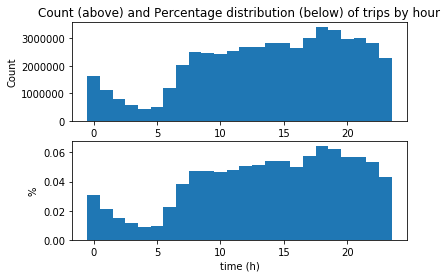

In [0]:
pd_df = sqlDF.toPandas()

plt.subplot(2, 1, 1)
plt.bar(pd_df['trip_hour'], pd_df['TRIP_COUNT'], 1)
plt.title('Count (above) and Percentage distribution (below) of trips by hour')
plt.ylabel('Count')

plt.subplot(2, 1, 2)
plt.bar(pd_df['trip_hour'], pd_df['TRIP_COUNT']/pd_df['TRIP_COUNT'].sum(), 1)
plt.ylabel('%')
plt.xlabel('time (h)')

From the above plot we can say that the trips gradually decrease from 10 PM till 5 AM where trips start to steeply increase until it almost plateaus at 8 AM. The peak time for the most trips taken is at 6 PM and 7 PM

Text(0.5,0,'time (h)')

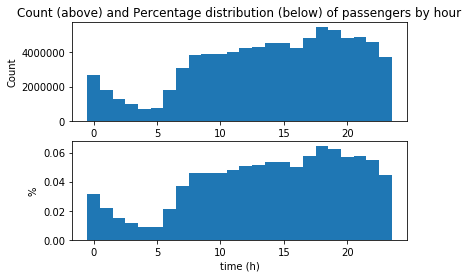

In [0]:
plt.subplot(2, 1, 1)
plt.bar(pd_df['trip_hour'], pd_df['PASSENGER_COUNT'], 1)
plt.title('Count (above) and Percentage distribution (below) of passengers by hour')
plt.ylabel('Count')

plt.subplot(2, 1, 2)
plt.bar(pd_df['trip_hour'], pd_df['PASSENGER_COUNT']/pd_df['PASSENGER_COUNT'].sum(), 1)
plt.ylabel('%')
plt.xlabel('time (h)')

How much does your ride cost vary by hour?

Text(0.5,0,'time (h)')

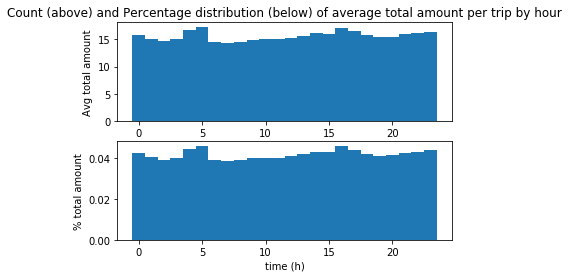

In [0]:
plt.subplot(2, 1, 1)
plt.bar(pd_df['trip_hour'], pd_df['AVG_TOTAL_AMT'], 1)
plt.title('Count (above) and Percentage distribution (below) of average total amount per trip by hour')
plt.ylabel('Avg total amount')

plt.subplot(2, 1, 2)
plt.bar(pd_df['trip_hour'], pd_df['AVG_TOTAL_AMT']/pd_df['AVG_TOTAL_AMT'].sum(), 1)
plt.ylabel('% total amount')
plt.xlabel('time (h)')

While we know that the trip count is least at between 4 AM and 6 AM the average total amount collected is higher than compared to fares collected during peak hours. This may be due to the passengers being charged more for the trips taken during these odd hours (4 AM and 6 AM)

How the speed of the cabs vary by hour?

Text(0.5,0,'time (h)')

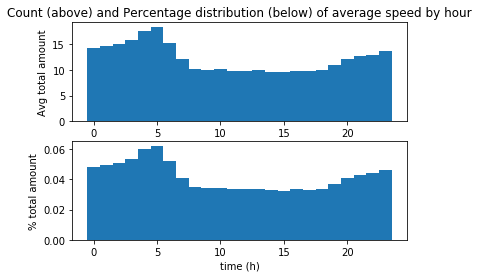

In [0]:
plt.subplot(2, 1, 1)
plt.bar(pd_df['trip_hour'], pd_df['AVG_SPEED'], 1)
plt.title('Count (above) and Percentage distribution (below) of average speed by hour')
plt.ylabel('Avg total amount')

plt.subplot(2, 1, 2)
plt.bar(pd_df['trip_hour'], pd_df['AVG_SPEED']/pd_df['AVG_SPEED'].sum(), 1)
plt.ylabel('% total amount')
plt.xlabel('time (h)')

The average speed is plateaued starting at the rush hour (8 AM) and it is consistent at 10 MPH till the evening (7 PM) where the speeds gradually starts to increase and reaches about 20 MPH between (4 AM and 6 AM) this is possibly due to the low traffic during these odd hours. This could also mean the driver can make more trips during these hours and as we have seen above the fares charged are high during these hours.

Hourly distribution of the percentage of trips taken by VendorID

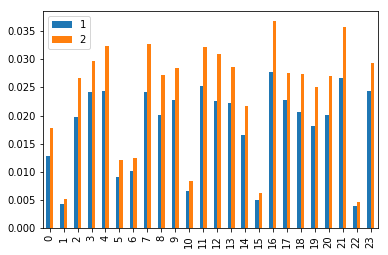

In [0]:
scaled = csv_data.crosstab("trip_hour", "VendorID")
pd_bar = scaled.toPandas()
sum_ = pd_bar[['1','2']].sum(axis = 0).sum()
pd_bar = pd_bar[['1','2']]/sum_
pd_bar.plot.bar()

The above graph shows that Vendor 2 always does more trips than Vendor 1 possibly due to more taxis in Vendor 2 fleet.

Monthly distribution of the percentage of trips taken by VendorID

1    43.376907
2    56.623093
dtype: float64

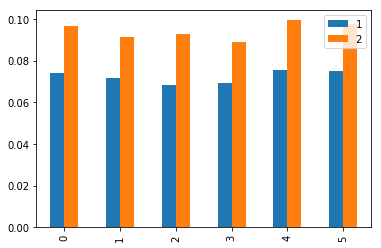

In [0]:
scaled = csv_data.crosstab("trip_month", "VendorID")
pd_bar = scaled.toPandas()
sum_ = pd_bar[['1','2']].sum(axis = 0).sum()
pd_bar = pd_bar[['1','2']]/sum_
pd_bar.plot.bar()
pd_bar.sum()*100

The above graph shows that the monthly distribution of trips is consistent at about 43:57 i.e, Vendor 1 has a market share of about 43% while the rest 57% is captured by Vendor 2

What are the means of payment for the trips taken by customers?

Credit Card    70.044843
Cash           29.480752
No charge       0.367160
Dispute         0.107245
dtype: float64

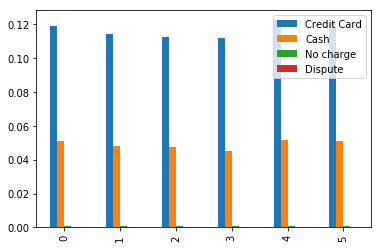

In [0]:
scaled = csv_data.crosstab("trip_month", "Payment_type")
pd_bar = scaled.toPandas()
pd_bar = pd_bar.rename(index=str, columns={"1": "Credit Card", "2": "Cash", "3": "No charge", "4": "Dispute", "5": "Unknown", "6": "Voided trip"})
sum_ = pd_bar[list(pd_bar)[1:]].sum(axis = 0).sum()
pd_bar = pd_bar[list(pd_bar)[1:]]/sum_
pd_bar.plot.bar()
pd_bar.sum()*100

Less than 0.8% of the trips end up to be free rides or becomes disputes.

Which rate codes are mostly used?

Standard rate            98.127445
JFK                       1.847312
Newark                    0.001652
Nassau or Westchester     0.014313
Negotiated fare           0.009258
Group ride                0.000019
dtype: float64

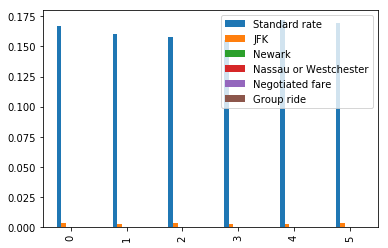

In [0]:
scaled = csv_data.crosstab("trip_month", "RateCodeID")
pd_bar = scaled.toPandas()
pd_bar = pd_bar.rename(index=str, columns={"1": "Standard rate", "2": "JFK", "3": "Newark", "4": "Nassau or Westchester", "5": "Negotiated fare", "6": "Group ride"})
sum_ = pd_bar[list(pd_bar)[1:]].sum(axis = 0).sum()
pd_bar = pd_bar[list(pd_bar)[1:]]/sum_
pd_bar.plot.bar()
pd_bar.sum()*100

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeans

from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors

Clustering using KMeans() from MLlib in Spark

In [0]:
cols = ['passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'tip_amount',
 'tolls_amount',
 'trip_time']
# , 'trip_hour', 'avg_trip_speed'
assembler = VectorAssembler(inputCols=cols, outputCol='features')
assembled_data = assembler.transform(csv_data)
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)
scaled_data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- trip_time: double (nullable = true)
 |-- trip_month: integer (nullable = true)
 |-- trip_hour: integer (nullable = true)
 |-- avg_trip_speed: double (nullable = true)
 |-- worst_case_fare: double (nullable = true)
 

In [0]:
scaledData = scaler_model.transform(assembled_data).drop('features').withColumnRenamed('scaledFeatures', 'features')
scaledData.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- trip_time: double (nullable = true)
 |-- trip_month: integer (nullable = true)
 |-- trip_hour: integer (nullable = true)
 |-- avg_trip_speed: double (nullable = true)
 |-- worst_case_fare: double (nullable = true)
 

In [0]:
scaledData.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+----------+---------+--------------+---------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_time|trip_month|trip_hour|avg_trip_speed|worst_case_fare|            features|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+----------+---------+--------------+---------------+--------------------+
|       1| 2018-01-01 00:21:05|  2018

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [0]:
# Trains a k-means model on scaled data.
scaled_kmeans2 = KMeans().setFeaturesCol("features").setPredictionCol("prediction").setK(2).setSeed(1)
sc_model2 = scaled_kmeans2.fit(scaledData)

# Make predictions
sc_predictions2 = sc_model2.transform(scaledData)

# Evaluate clustering by computing Silhouette score
sc_evaluator2 = ClusteringEvaluator()

sc_silhouette2 = sc_evaluator2.evaluate(sc_predictions2)
print("Silhouette with squared euclidean distance = " + str(sc_silhouette2))

# Shows the result.
sc_centers2 = sc_model2.clusterCenters()
print("Cluster Centers: ")
for center in sc_centers2:
  print(center)

Silhouette with squared euclidean distance = 0.8296051722800406
Cluster Centers: 
[1.27888492 0.56081329 1.01017401 0.71433942 0.60858197 0.00474355
 1.03400608]
[1.31086716 3.54290573 3.93661831 1.00677495 2.68769812 2.20184687
 3.49198221]


In [0]:
[cluster * scaler_model.std + scaler_model.mean for cluster in sc_model2.clusterCenters()]

[array([ 3.19976006,  4.80303499, 22.31583384,  0.65561035,  3.22262513,
         0.29281783, 25.60323789]),
 array([ 3.23972786, 15.24695666, 51.14230526,  0.7875447 ,  8.03832709,
         3.61706647, 53.27897486])]

In [0]:
sc_predictions2.createOrReplaceTempView("sc_predictions2")
# spark.sql("SELECT prediction, count(prediction) FROM sc_predictions2 GROUP BY prediction").show()
sc_predictions2.groupBy('prediction').count().show()

+----------+--------+
|prediction|   count|
+----------+--------+
|         1| 4395756|
|         0|48079459|
+----------+--------+



Stratified sampling by clusters to perform analysis on the sample data in GraphX

In [0]:
seed = 1234
fractions1 = sc_predictions2.select("prediction").distinct().withColumn("fraction1", lit(0.01)).rdd.collectAsMap()
print(fractions1)                                                            
sampled_df1 = sc_predictions2.stat.sampleBy("prediction", fractions1, seed)
sampled_df1.show()

{1: 0.01, 0: 0.01}
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+----------+---------+--------------+---------------+--------------------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_time|trip_month|trip_hour|avg_trip_speed|worst_case_fare|            features|prediction|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+----------+---------+--------------+---------------+------------------

In [0]:
sampled_df1.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1| 43754|
|         0|481086|
+----------+------+



In [0]:
# sampled_df.toPandas().write_csv('sampled_df.csv')
sampled_df1.toPandas().to_csv('./sampled_df1.csv', header=True)